 # Using Python to solve ODEs
 
 In this notebook we will look at how to solve ODEs in Python using the `solve_ivp` function and the solvers it provides. We will also look at the old API, namely `odeint` and `ode`. As usual we begin with the standard Numpy and Matplotlib imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

The capability to solve ODEs is provided by the `scipy` package, in particular [`scipy.integrate`](https://docs.scipy.org/doc/scipy/reference/integrate.html)

In [2]:
from scipy.integrate import solve_ivp

## Solving First Order ODEs

Consider the dimensionless [logistic growth equation](https://en.wikipedia.org/wiki/Logistic_function#In_ecology:_modeling_population_growth)

$$
\frac{\mathrm{d}y}{\mathrm{d}t} = y(1-y), \quad y(0)=\frac{1}{2}.
$$
The analytic solution is given by
$$
y(t) = \frac{1}{1+\mathrm{e}^{-t}}
$$
To solve this numerically, we first write this in the form $y' = f(t,y)$ and type the right hand side as a function:

In [3]:
def logistic_ode(t, y):
    f = y * (1 - y)
    return f

The `solve_ivp` function requires 3 inputs:  #TODO
- `fun`: the function $f(t,y)$ that defines the right hand side of the ODE. Here $t$ is a scalar and $y$ is a matrix (`ndarray`).
- `t_span`: A vector or tuple of floats, $\left[t_0 ,t_f\right]$ where $t_0$ is the time from which to begin solving and $t_f$ is the time to end solving.
- `y0`:  A vector of initial conditions.

The documentation for the `solve_ivp` function is [available here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp), scroll down for examples!

The solution is output as an object, which here is named `sol`. The times at which the ODE was solved is stored as a vector in `sol.t` and the solution will be a matrix stored in `sol.y`. **Note: these will be called `sol.t` and `sol.y` irrespective of the variables in the ODE function.**

In [4]:
sol = solve_ivp(logistic_ode, (0,10), [0.5])
t = sol.t
y = sol.y

By default, the `solve_ivp` uses an [Explicit Runge-Kutta method of order 5(4)](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.RK45.html#scipy.integrate.RK45). This will be roughly equivalent to MATLAB's `ode45` function. In most cases this should be your first port of call when numerically solving an ODE. Later we will look at the other solvers available within Python.

We can plot the solution and the true solution in the same plot.

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


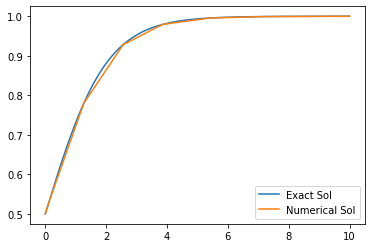

In [5]:
def logistic_sol(t):
    return 1 / (1 + np.exp(-t))

t_exact = np.arange(0,10, 0.00001)
plt.plot(t_exact, logistic_sol(t_exact), label="Exact Sol")
plt.plot(t,y[0,:], label="Numerical Sol")
plt.legend()
plt.show()


We can also plot the error at each solution point.

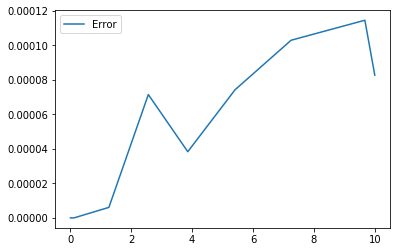

In [6]:
plt.plot(t, np.abs(y[0,:]-logistic_sol(t)), label="Error")
plt.legend()
plt.show()

### Reducing the Error Tolerances
There are two keyword inputs to `solve_ivp` that control the tolerable error. These are the relative tolerance `rtol` and the absolute tolerance `atol`. The solver keeps the error estimates aproximately less than `atol + rtol *abs(y)`. By default `atol`$=1e-6$ and `rtol`$=0.001$, which means for the logistic equation here the error should always be

`atol + rtol *abs(y)`$ \approx 10^{-6} + 0.001 \times \mathrm{abs}(y) \leq 10^{-6} + 0.001 \times 1 = 0.001001. $
The graph above shows that in this case the solver has beaten this bound by an order of magnitude. If more accuracy is required,  `atol` and `rtol` can be adjusted:

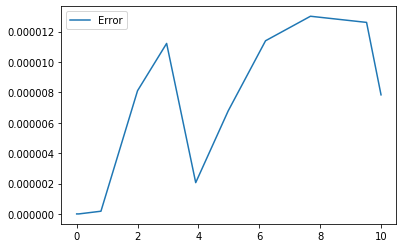

In [7]:
sol_accurate = solve_ivp(logistic_ode, [0,10], [0.5], atol=1e-7,rtol=1e-4)
t_accurate = sol_accurate.t
y_accurate = sol_accurate.y
# plotting
plt.plot(t_accurate, np.abs(y_accurate[0,:]-logistic_sol(t_accurate)),label="Error")
plt.legend()
plt.show()

## Second Order ODEs
Similar to MATLAB, Python only deals with first order ODEs. Consider the [damped harmonic oscillator](https://en.wikipedia.org/wiki/Harmonic_oscillator#Damped_harmonic_oscillator) governed by 
$$
\ddot{x} +\omega \dot{x} + x =0  
$$

This can be rewritten as two coupled first order ODEs:
$$
\begin{cases}
    \dot{x} &= y\\
    \dot{y} &= - \omega y - x\\
\end{cases}
$$
This time our function must return a vector, with one element for the $x$ equation and one for the $y$ equation. We denote $z = \begin{pmatrix}x\\y\end{pmatrix}$


In [8]:
def damped_osc_ode(t, z, omega):
    x, y = z
    return [y, -omega * y - x]

This will return a vector,
$$
f = \begin{pmatrix}
     y\\ -\omega y - x
    \end{pmatrix}.
$$
Solving the system is the similar to the first-order case, however we must supply two initial conditions: one for $x$ and one for $y$. Also, the damped harmonic equation contains an extra fixed parameter $\omega$. This is passed to the solver using `args=omega`. The `args` keyword parameter must be an iterable, i.e. a tuple. If only one parameter is passed it must be in the form:
```
args = (param,)
```
This tells Python to interpret this as a tuple and not just an integer or a float.

**Note: before Scipy 1.4, the `args` parameter was not used. Check your version of Scipy if this does not work** If using Scipy<1.4, use a lambda function as described [here](https://github.com/scipy/scipy/issues/8352#issuecomment-362918089). 

In [25]:
omega = 1
sol = solve_ivp(damped_osc_ode, [0,10], [1,0], args=(omega,))

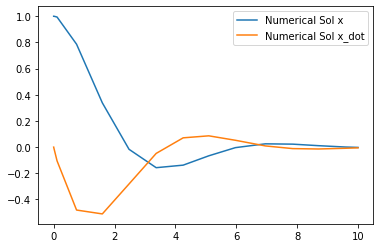

In [26]:
t = sol.t
y = sol.y
plt.plot(t,y[0,:], label="Numerical Sol x")
plt.plot(t,y[1,:], label="Numerical Sol x_dot")
plt.legend()
plt.show()

## Stiff Problems (Alternate Solvers)

There are of course scenarios where RK45 is not a good enough solver. This is usually the case when solving a stiff problem, for example the Van der Pol oscillator.
$$
\ddot{x} = \mu (1-x^2)\dot{x} - x.
$$
This can be written as a pair of first order ODEs:
$$
\begin{cases}
    \dot{y}_0 &= y_1\\
    \dot{y}_1 &= \mu (1-y_0^2)y_1 - y_0
\end{cases}
$$
Let $y_0(0) = 2, y_1(0) = 0, \mu = 1000 $. These are chosen to coincide with the example in the [MATLAB documentation](https://uk.mathworks.com/help/matlab/ref/ode15s.html)


In [ ]:
def vdp_ode(t,y,mu):
    f = np.zeros(2)
    f[0] = y[1]
    f[1] = mu*(1-y[0]**2)*y[1] - y[0]
    return f

If we were to solve this without specifying a `method`, Scipy would default to the `RK45` solver. This will result in a very long computation time as the scheme must refine the stepsize a huge amount before the tolerance is met. I'd recommend not running the cell below, unless you have a lot of time to spare!

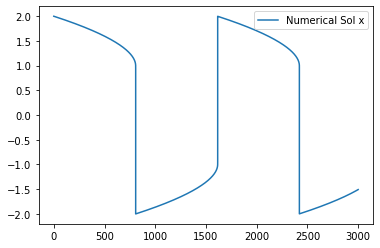

In [58]:
mu = 1000

sol = solve_ivp(vdp_ode, [0,3000], [2,0], args=(mu,))
t = sol.t
y = sol.y
plt.plot(t,y[0,:], label="Van der Pol Oscillator")
plt.legend()
plt.show()

Instead, it is better to use one of Scipy's stiff solvers. There are three, in order of preference:
- `Radau`, an implicit Runge-Kutta of the Radau IIA family of order 5

- `BDF`, an implicit multi-step variable order method based on a backward differentiation formula. This is approximately equivalent to MATLAB's `ode15s` solver.
- `LSODA`, an Adams/BDF method with automatic stiffness detection -- this is based on the Fortran solver ODEPACK

Here we use `BDF`, it decreases the computation time considerably

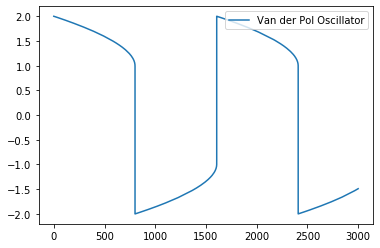

In [100]:
mu = 1000

sol = solve_ivp(vdp_ode, [0,3000], [2,0], args=(mu,), method="BDF")
t = sol.t
y = sol.y
plt.plot(t,y[0,:], label="Van der Pol Oscillator")
plt.legend()
plt.show()

The implicit methods require the approximation of the Jacobian at every timestep. To improve accuracy, this can be passed to the solver. If no Jacobian is passed, it will be approximated using finite differences. For the Van der Pol oscillator, the Jacobian is
$$
J = \begin{pmatrix}
    0 & 1\\
    2\mu y_0 y_1-1 & \mu(1-y_0^2)
    \end{pmatrix}
$$

In [71]:
def vdp_jac(t,y,mu):
    J = np.zeros((2,2))
    J[0,0] = 0
    J[0,1] = 1
    J[1,0] = 2*mu*y[0]*y[1] -1 
    J[1,1] = mu * (1 - y[0]**2)
    return J

Note the change of method here to `Radau` doing so considerably speeds up computation time.

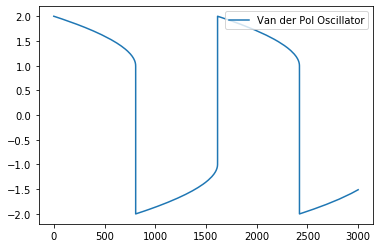

In [98]:
mu = 1000

sol_acc = solve_ivp(vdp_ode, [0,3000], [2,0], args=(mu,), method="Radau", jac=vdp_jac)
t_acc = sol_acc.t
y_acc = sol_acc.y
plt.plot(t_acc,y_acc[0,:], label="Van der Pol Oscillator")
plt.legend()
plt.show()

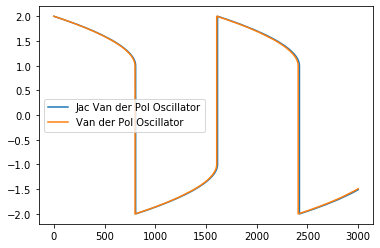

In [101]:
plt.plot(t_acc,y_acc[0,:], label="Jac Van der Pol Oscillator")
plt.plot(t,y[0,:], label="Van der Pol Oscillator")
plt.legend()
plt.show()